In [11]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
#! unzip data.zip

In [13]:
# Training Data
x_train = np.array(pd.read_csv('data/training_set.csv', header=None).values)
y_train = np.array(pd.read_csv('data/training_labels_bin.csv', header=None).values)
x_val = np.array(pd.read_csv('data/validation_set.csv', header=None).values)
y_val = np.array(pd.read_csv('data/validation_labels_bin.csv', header=None).values)

In [14]:
N = len(x_train)
M = len(x_val)
print(N)
print(len(y_train))
print(M)
print(len(y_val))

8442
8442
1048
1048


In [15]:
num_feats = x_train.shape[1]
n_out = y_train.shape[1]
print(num_feats)
print(n_out)

354
3


In [16]:
# add a row of 1s, to be multiplied by the bias in the first hidden layer, easy way to not have to explicitly handle the backprop of bias as a unique case
bias_train = np.ones((x_train.shape[0], 1))
bias_val = np.ones((x_val.shape[0], 1))
x_train = np.append(x_train, bias_train, axis = 1)
x_val = np.append(x_val, bias_val, axis = 1)

In [17]:
# sigmoid function
def sigmoid(x):
  return 1/(1+np.exp(-x))

# gradient of sigmoid using a common identity
def grad_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

# sum of squared error
def squared_error(guess, correct):
  return sum((guess-correct)**2)

# gradient of the sum of squared erros
def grad_squared_error(guess, correct):
  grad_vec = np.zeros(len(guess))
  for j in range(len(guess)):
    grad_vec[j] = 2*(guess[j]-correct[j])
  return np.reshape(grad_vec, (1, len(grad_vec)))

# fully connected, 2 hidden layers, vector of size 3 output
# we assume an input of 1x355 with the last entry a 1
class MLP:
  def __init__(self):
    # initialize the hidden layers [354x354], [354x354] and [354, 3] <- W3 is the out layer
    W1 = np.random.uniform(-1, 1, num_feats*num_feats).reshape((num_feats, num_feats))
    W2 = np.random.uniform(-1, 1, num_feats*num_feats).reshape((num_feats, num_feats))
    W3 = np.random.uniform(-1, 1, num_feats*3).reshape((num_feats, 3))

    # put the bias into the first weight matrix so the addition is a simply result of matrix multiplication
    # initialize a bias, so only the first hidden layer has a bias
    bias = np.random.uniform(-1, 1, 354)
    W1 = np.append(W1, np.array([bias]), axis = 0)
    # put the values that needed to be saved into tables
    self.w = [W1, W2, W3]
    self.a = [np.zeros((1, 354)), np.zeros((1, 354)), np.zeros((1, 3))]
    self.h = [np.zeros((1, 354)), np.zeros((1, 354)), np.zeros((1, 3))] # <- h[2] is the prediction of the model
    # grad table simply holds the gradients of the weights
    self.grad_table = [W1, W2, W3]
    return

  # follows the algorithm in backpropagation lecture
  def forward_pass(self, src, sink):
    # have to reshape the inputs into matrices so matmul works as a dot
    src = np.reshape(src, (1, 355))
    sink = np.reshape(sink, (1, 3))

    # simply forward pass using sigmoid activations
    self.a[0] = np.matmul(src, self.w[0])
    self.h[0] = sigmoid(self.a[0])
    self.a[1] = np.matmul(self.h[0], self.w[1])
    self.h[1] = sigmoid(self.a[1])
    self.a[2] = np.matmul(self.h[1], self.w[2])
    self.h[2] = sigmoid(self.a[2])
    # store the sum of squared error so as to access after pass
    self.J = squared_error(self.h[2][0], sink[0])

  # follows the algorithm in backpropagation lecture, I reversed transpositions
  def backprop(self, src, sink, lr):
    # have to reshape the inputs into matrices so matmul works as a dot
    sink = np.reshape(sink, (1, 3))
    src = np.reshape(src, (1, 355))

    # set g = dJ/dy_bar
    g = grad_squared_error(self.h[2][0], sink[0])
    # backprop the value of g and use it to traverse the chain rule of differentiation backward, updating the weights as we pass them
    for i in range(2, -1, -1):
      # set g = dJ/dai as dJ/dai = (dJ/dhi)*f'(ai)
      # (as shown in class via observance that element-wise multiplication and matrix multiplication are identical for diagonal matrices)
      g = g*grad_sigmoid(self.a[i])
      if i==0:
        # h0 (h[-1]) = src (the input)
        # have dJ/dW1 = (dJ/da0)(da0/dW1) where W1(*)h0 = a1 => da0/dW1 = h0
        self.grad_table[i] = np.matmul(src.T, g)
      else:
        # have dJ/dWi = (dJ/dai)(dai/dWi) where Wi(*)hi-1 = ai => dai/dWi = hi-1
        self.grad_table[i] = np.matmul(self.h[i-1].T, g)
      # As Wi(*)hi-1 = ai => dai/dhi-1 = Wi, set g = dJ/dai(*)Wi = (dJ/dai)(dai/dhi-1) = dJ/dhi-1
      g = np.matmul(g, self.w[i].T)
      # do the gradient descent AFTER propogating g to the next level
      # ie., W = W - lr*dJ/dW
      self.w[i] -= lr*self.grad_table[i]

In [18]:
# hyperparameters
eta = 0.1 # intial learning rate
stepsize = 25 # epochs before changing learning rate
max_epoch = 55

In [19]:
# create a perceptron and lists to store the average validation and training scores per epoch
perceptron = MLP()
validation_scores = []
training_scores = []

for epoch in range(0, max_epoch):
    
    # shuffle data
    order = np.random.permutation(N)
    
    sse = 0
    for n in range(0, N):
        idx = order[n]

        # get a sample (batch size=1)
        x_in = x_train[idx]
        y = y_train[idx]

        # forward and and backward pass through using the input
        perceptron.forward_pass(x_in, y)
        perceptron.backprop(x_in, y, eta)

        # add the sse to our running total
        sse += perceptron.J

    # divide running total by number of inputs to get average
    train_mse = sse/N
    # store the average for the last epoch
    training_scores.append(train_mse)
    
    # repeat for the validation set but without a backward pass
    sse = 0
    for m in range(0, M):
        perceptron.forward_pass(x_val[m], y_val[m])
        sse+=perceptron.J
        
    val_mse = sse/M
    validation_scores.append(val_mse)

    # after stepsize epochs decrease the learning rate by an order of magnitude
    if epoch % stepsize == 0 and epoch != 0:
        eta *= .1
        print('Changed learning rate to lr=' + str(eta))

Changed learning rate to lr=0.010000000000000002
Changed learning rate to lr=0.0010000000000000002


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

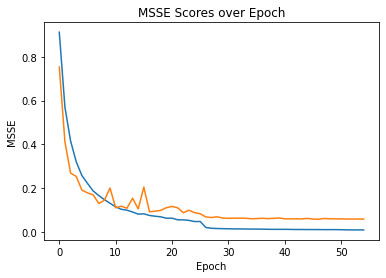

In [22]:
from google.colab import files
x = np.arange(55)
plt.title("MSSE Scores over Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSSE")
plt.plot(x, training_scores, label = 'training scores')
plt.plot(x, validation_scores, label = 'validation scores')
plt.savefig('solutions.pdf')
files.download('solutions.pdf')
plt.show()